In this notebook we'll just run a quick computation to check the algebra in the notes for the marginal likelihood of the PL under a uniform prior.

In [22]:
source("../code/bplaw_aux.r")

In [57]:
library(poweRlaw)
data(moby)
thedata <- moby
power_law_raw <- displ$new(thedata) 
raw_est <- estimate_xmin(power_law_raw)

lognorm <- dislnorm$new(thedata)
ln_est <-  estimate_xmin(lognorm)

## lower threshold under both distributions
mm_pl <- raw_est$xmin 
mm_ln <- ln_est$xmin

mm_ln;mm_pl
mmin <- mm_pl
power_law_raw$setXmin(mmin)
lognorm$setXmin(mmin)

[1] 3

[1] 7

In [58]:
dat <- thedata[thedata > mmin]
dist.data <- list(
  N = length(dat),
  x = dat,
  x_min = mmin,
  lower_alpha = 1.5,
  upper_alpha = 3
)

In [59]:
library(rstan)
rstan_options(auto_write = TRUE)

In [60]:
### Power law
tPL.model <- stan_model(file = "../code/stan/power_law_fixedMin_uniformPrior.stan",
                       save_dso = TRUE)
posterior_tPL  <- sampling(tPL.model, data = dist.data, iter = 2000, refresh = 0)
posterior_tPL

Inference for Stan model: power_law_fixedMin_uniformPrior.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd      2.5%       25%       50%       75%     97.5%
alpha      1.9    0.00 0.02      1.86      1.89      1.90      1.91      1.93
lp__  -10827.8    0.02 0.69 -10829.71 -10827.95 -10827.53 -10827.35 -10827.29
      n_eff Rhat
alpha  1399    1
lp__   1849    1

Samples were drawn using NUTS(diag_e) at Mon Jan  7 17:56:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

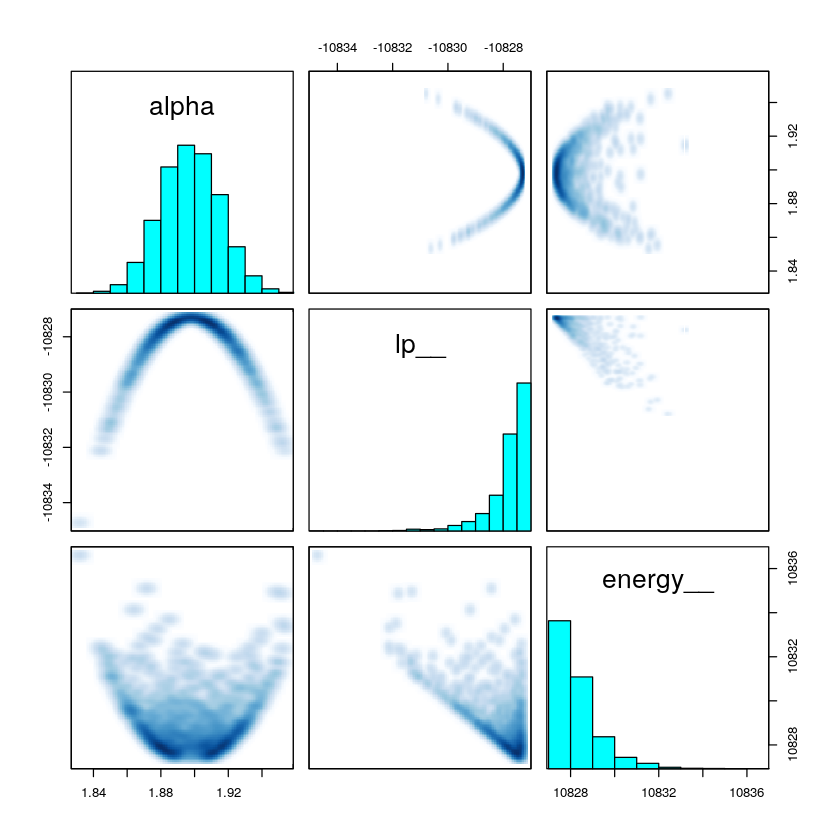

In [61]:
pairs(posterior_tPL)

In [62]:
library(bridgesampling)
summary( mal_est_tPL  <- bridgesampling::bridge_sampler(posterior_tPL) )

Warning message:
“effective sample size cannot be calculated, has been replaced by number of samples.”

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


Logml_Estimate,Relative_Mean_Squared_Error,Coefficient_of_Variation,Percentage_Error,Method,Repetitions
-10829.18,8.451051e-08,0.0002907069,0.0291%,normal,1


In [63]:
get_log_marg_lik_pwL_uniform <- function(x, m, l, u){
    if(l < 1) stop("Need l to be bigger than 1")
    if(u < l) stop("Upper bound u has to be strictly larger than lower bound l")
    if(any(x < m)) stop("Some of the observations are smaller than m")    
  ## returns the log-marginal likelihood under a power law model with a Uniform(l, u) prior on alpha
  w <- l-1
  y <- u-1        
  N <- length(x)
  logProd <- sum(log(x))
  logZ <- N * log(m) - logProd
  ### 
  lDenom <- logDiffExp( lgamma_inc(N, -w * logZ), lgamma_inc(N, -y * logZ))      
  lNum <- log(u-l) + logProd + N * log(-logZ)
  ans <- lDenom - lNum
  return(ans)      
}

In [65]:
cat("analytical: ", get_log_marg_lik_pwL_uniform(dist.data$x, dist.data$x_min, l = 1.5, u = 3), "\n")
cat("Bridge sampling: ", mal_est_tPL$logml, "\n")

analytical:  -10829.08 
Bridge sampling:  -10829.18 


Seems acceptable to me, but will investigate why there seems to be a discrepancy of $\approx \exp(1/10) = 1.1$.